In [ ]:
#imports
import zipfile
import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle as shuffle_dataframe
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
# From sensorlogger generated csv to pandas dataframe for training/testing ADL instance generation

def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)  # Filter coefficients
    y = filtfilt(b, a, data)
    return y

def sensorLoggerCSVtoADLDatasetDF(sensorLoggerCSV, hardCodedLabel=0):
    pd_accel = pd.read_csv(sensorLoggerCSV)
    magList = np.sqrt(pd_accel["x"]**2 + pd_accel["y"]**2 + pd_accel["z"]**2)
    cutoff_frequency = 5  # 5 hz cutoff frequency
    sampling_frequency = 100  # Sampling frequency (set to same in SensorLogger app)
    filtered_magnitude = butter_lowpass_filter(magList, cutoff_frequency, sampling_frequency)
    magList = filtered_magnitude
    newDF = pd.DataFrame(columns=['magnitude', 'label'])
    for i in range(int(np.floor(len(magList)/350)) -1): # Mimic the overlapping buffers at server side
        new_row = pd.DataFrame([{'label': hardCodedLabel, 'magnitude': magList[i*350:(i+2)*350]}])
        newDF = pd.concat([newDF, new_row], ignore_index=True)
    return newDF

In [ ]:
# collective dataframe's adl data

# ADL csv #1
df_all_adl1 = sensorLoggerCSVtoADLDatasetDF("ADHL.csv", 0)
# ADL csv #2
df_all_adl2 = sensorLoggerCSVtoADLDatasetDF("fenste_cesitli_adl.csv", 0)

# grouped
df_all_adl = pd.concat([df_all_adl1, df_all_adl2], ignore_index=True)

In [ ]:
# Check data format
print(df_all_adl.head()) # magnitude and label, length = 677
print(df_all_adl.shape, len(df_all_adl['magnitude'][17])) # randomly selected 17th instance for checking

                                           magnitude label
0  [0.10862444767918161, 0.12015273550077053, 0.1...     0
1  [1.444881831370672, 1.400732918822068, 1.36796...     0
2  [3.3084275101015432, 3.333994796347804, 3.3400...     0
3  [1.6737453314664086, 1.549882802317406, 1.4348...     0
4  [1.4447371474180417, 1.4496534504870808, 1.446...     0
(677, 2) 700


In [ ]:
#Check types, should be numpy array

#print(type(df_all_adl['magnitude'][17])) # type = numpy.ndarray
#print(type(df_all_adl['magnitude'][17][24])) # type = numpy.float64


<class 'numpy.ndarray'>
<class 'numpy.float64'>


In [ ]:
## From sensorlogger generated csv to pandas dataframe for training/testing Fall instance generation

def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)  # Filter coefficients
    y = filtfilt(b, a, data)
    return y

def ZiptoSensorLoggerCSVtoFallDatasetDF(zip_file_path, label):
    """
    Parse CSV files in a zip archive, compute filtered magnitudes, and return a DataFrame.

    Parameters:
    - zip_file_path: Path to the zip file containing CSV files.
    - label: A label to assign to each processed row in the output DataFrame.

    Returns:
    - A DataFrame with columns ['magnitude', 'label'].
    """
    cutoff_frequency = 5
    sampling_frequency = 100 # same in Sensor Logger app
    final_df = pd.DataFrame(columns=["magnitude", "label"])

    with zipfile.ZipFile(zip_file_path, 'r') as zf:
        # Iterate over each file in the zip
        for file_name in zf.namelist():
            if file_name.endswith('.csv'):  # only process CSV files
                with zf.open(file_name) as f:
                    df = pd.read_csv(f)
                    # Compute magnitude
                    mag_list = np.sqrt(df["x"][:700]**2 + df["y"][:700]**2 + df["z"][:700]**2)

                    if len(mag_list) != 700:  # some frames may not have arrived as 700, but longer
                        print(f"Skipping file {file_name} due to length mismatch.")
                        continue

                    filtered_magnitude = butter_lowpass_filter(mag_list,
                                                               cutoff_frequency,
                                                               sampling_frequency)

                    # Ensure magnitude is stored as a NumPy array of np.float64
                    filtered_magnitude = np.array(filtered_magnitude, dtype=np.float64)

                    # Add a row to the final DataFrame
                    final_df = pd.concat([final_df, pd.DataFrame({
                        "magnitude": [filtered_magnitude],  # Store as ndarray
                        "label": [label]
                    })], ignore_index=True)

    return final_df


In [ ]:
# collective dataframe's fall data
df_all_fall = ZiptoSensorLoggerCSVtoFallDatasetDF("fall.zip", 1) # 1 is the class of Fall

In [ ]:
# # Check data format
print(df_all_fall.head()) # magnitude and label, length = 252
print(df_all_fall.shape, len(df_all_fall['magnitude'][17])) # randomly selected 17 for checking


                                           magnitude label
0  [0.5328667607151071, 0.5195322355717552, 0.505...     1
1  [1.5904970367859106, 1.8890880248191795, 2.181...     1
2  [2.8853236893637364, 4.322460662583523, 5.7606...     1
3  [1.842108267908963, 1.7704485758638333, 1.7088...     1
4  [1.2664707778494908, 1.181644630166627, 1.0997...     1
(252, 2) 700


In [ ]:
# Check the types, should be numpy array
#print(type(df_all_fall['magnitude'][17])) # type = numpy.ndarray
#print(type(df_all_fall['magnitude'][17][24])) # type = numpy.float64

<class 'numpy.ndarray'>
<class 'numpy.float64'>




---


in total, we have

* 677 non-fall frames

* 252 fall frames


---



In [ ]:
# partition into train(75%) and test(25%), and save each as csv for checkpoint saving

def split_and_concatenate(df_0, df_1, split_ratio=0.8, random_state=None, shuffle=True):
    """
    Splits two dataframes into train and test sets, concatenates the respective train and test sets,
    and returns the concatenated dataframes.

    Parameters:
    - df_0, df_1: DataFrames with "magnitude" and "label" columns.
    - split_ratio: Fraction of data to use for training (default is 0.8).
    - random_state: Seed for reproducibility (default is None).
    - shuffle: Whether to shuffle the data before splitting (default is True).

    Returns:
    - concatenated_train: DataFrame containing the concatenated training data.
    - concatenated_test: DataFrame containing the concatenated testing data.
    """
    # Split dataframe_0
    train_0, test_0 = train_test_split(df_0, train_size=split_ratio, random_state=random_state, shuffle=shuffle)

    # Split dataframe_1
    train_1, test_1 = train_test_split(df_1, train_size=split_ratio, random_state=random_state, shuffle=shuffle)

    # Concatenate the train and test sets from both dataframes
    concatenated_train = pd.concat([train_0, train_1], ignore_index=True)
    concatenated_test = pd.concat([test_0, test_1], ignore_index=True)

    # this way, ratio of fall in the training and testing is preserved
    concatenated_train = shuffle_dataframe(concatenated_train, random_state=random_state).reset_index(drop=True)

    return concatenated_train, concatenated_test


df_train, df_test = split_and_concatenate(df_all_fall, df_all_adl, split_ratio=0.75, random_state=42)


In [ ]:
# check the dfs
#print(df_train) # 696 rows
#print(df_test) # 233 rows

                                             magnitude label
0    [0.1326578051724844, 0.13283962244896616, 0.13...     0
1    [0.6083756484766984, 0.5905265785234092, 0.569...     0
2    [1.8035385855709463, 1.7782845838195986, 1.749...     0
3    [0.14354524599307067, 0.14884563015451394, 0.1...     0
4    [4.991880381135296, 5.164283039646422, 5.34169...     0
..                                                 ...   ...
691  [0.9083248511243021, 0.8580184370042581, 0.805...     1
692  [2.3426368375036732, 2.1251324920545858, 1.919...     1
693  [2.911069284341918, 3.114591253513609, 3.28247...     0
694  [0.1823601147091017, 0.18215057287687006, 0.18...     0
695  [3.221259909226104, 2.8945660093702137, 2.5765...     1

[696 rows x 2 columns]
                                             magnitude label
0    [8.199972858164518, 7.80967043429824, 7.439945...     1
1    [3.549445965355439, 3.147572596743873, 2.75440...     1
2    [1.8778259878237888, 1.8701325224613146, 1.862...     1


In [ ]:
# save the dataframes before training for easier access next time
df_train.to_csv('df_train.csv', index=False)
df_test.to_csv('df_test.csv', index=False)

In [ ]:
#print(type(df_train["magnitude"][42])) # <class 'numpy.ndarray'>
#print(type(df_train["magnitude"][42][42])) # <class 'numpy.float64'>

<class 'numpy.ndarray'>
<class 'numpy.float64'>


In [ ]:
#print(type(df_test["magnitude"][42])) # <class 'numpy.ndarray'>
#print(type(df_test["magnitude"][42][42])) # <class 'numpy.float64'>

<class 'numpy.ndarray'>
<class 'numpy.float64'>


In [ ]:
# Load the datasets
#df_train = pd.read_csv("df_train.csv")
#df_test = pd.read_csv("df_test.csv")

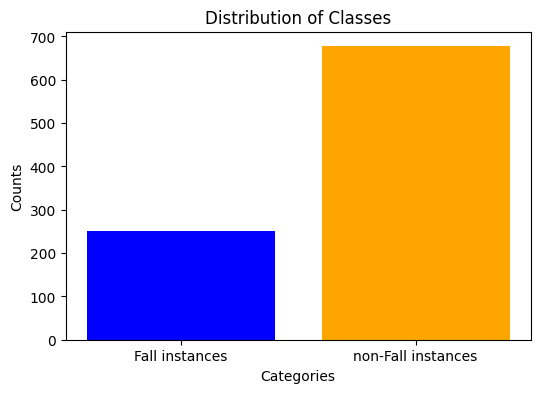

In [ ]:
import matplotlib.pyplot as plt

def create_bar_chart(label1, label2, count1, count2):
    """
    Creates a bar chart with two bins based on given labels and counts.

    Args:
        label1 (str): Label for the first bin.
        label2 (str): Label for the second bin.
        count1 (int or float): Count for the first bin.
        count2 (int or float): Count for the second bin.
    """
    labels = [label1, label2]
    counts = [count1, count2]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, counts, color=['blue', 'orange'])
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title('Distribution of Classes')
    plt.show()


create_bar_chart("Fall instances", "non-Fall instances", 252, 677)


In [ ]:
# construct the GRU model

model = Sequential([
    GRU(128, input_shape=(700, 1), return_sequences=True),  # GRU layer with 128 units
    Dropout(0.3),  # Dropout to prevent overfitting
    GRU(64, return_sequences=False),  # GRU layer with 64 units
    Dropout(0.3),  # Dropout for regularization
    Dense(32, activation='relu'),  # Fully connected layer
    Dropout(0.2),  # Dropout before output layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 700, 128)            │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 700, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,665 (350.25 KB)

 Trainable params: 89,665 (350.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# get ready for training

def prepare_training_testing_data(df_train, df_test):
    """
    Prepares training and testing data by separating features (X) and labels (Y).

    Parameters:
        df_train (pd.DataFrame): Training DataFrame with 'magnitude' and 'label' columns.
        df_test (pd.DataFrame): Testing DataFrame with 'magnitude' and 'label' columns.

    Returns:
        x_train, y_train: Features and labels for training.
        x_test, y_test: Features and labels for testing.
    """
    # Extract features (X) and labels (Y) for training data
    x_train = np.stack(df_train["magnitude"].values)  # Stack magnitudes into a 2D NumPy array
    y_train = df_train["label"].values.astype(np.float32)  # Convert labels to a NumPy array of float32

    # Extract features (X) and labels (Y) for testing data
    x_test = np.stack(df_test["magnitude"].values)  # Stack magnitudes into a 2D NumPy array
    y_test = df_test["label"].values.astype(np.float32)  # Convert labels to a NumPy array of float32

    return x_train, y_train, x_test, y_test


# Example usage:
x_train, y_train, x_test, y_test = prepare_training_testing_data(df_train, df_test)

print("x_train shape:", x_train.shape)  # e.g., (num_samples_train, 700)
print("y_train shape:", y_train.shape)  # e.g., (num_samples_train,)

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (696, 700)
y_train shape: (696,)
x_test shape: (233, 700)
y_test shape: (233,)


In [ ]:
# save splitted ndarrays for easier access
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)

In [ ]:
# load splitted ndarrays for easier access to do gpu training at the next step
#x_train = np.load('x_train.npy', allow_pickle=True)
#y_train = np.load('y_train.npy', allow_pickle=True)
#x_test = np.load('x_test.npy', allow_pickle=True)
#y_test = np.load('y_test.npy', allow_pickle=True)

In [ ]:
# training (run imports, model architecture and np.loads if running this on gpu)

log_dir = os.path.join("logs", "fit", "run_1")  # Change "run_1" for different training runs
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

history = model.fit(
    x_train,
    y_train,
    verbose=1,
    epochs=200,  # Number of epochs can be 20
    batch_size=32,
    validation_split=0.2,  # Use 20% of training data for validation
    callbacks=[tensorboard_callback]
)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.6586 - loss: 0.6166 - val_accuracy: 0.7214 - val_loss: 0.4583
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7317 - loss: 0.5022 - val_accuracy: 0.7214 - val_loss: 0.4533
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7075 - loss: 0.4878 - val_accuracy: 0.7214 - val_loss: 0.4196
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6591 - loss: 0.4937 - val_accuracy: 0.7214 - val_loss: 0.4158
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7213 - loss: 0.4574 - val_accuracy: 0.7214 - val_loss: 0.4045
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7097 - loss: 0.4418 - val_accuracy: 0.7214 - val_loss: 0.3949
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7365 - loss: 0.4360 - val_accuracy: 0.7357 - val_loss: 0.3809
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7257 - loss: 0.4356 - val_accuracy: 0.

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
# Save the trained model
model.save("my_gru_model.weights.h5")  # Save the model in HDF5 format


In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0011
Test Loss: 0.0009883396560326219
Test Accuracy: 1.0
